# Analisy results MOA mini-batching

The results compareds this work use follow variables.

Frequencies in MHz:

    - Minimum: 600Mhz, Maximum: 1200Mhz

Size mini-batching uses are:

    - 1 (Sequential without mini-batching)
    - 1 (Sequential with mini-batching)
    - 25 (Paralel 4 CPUs with mini batching)
    - 75 (Paralel 4 CPUs with mini batching)
    - 50 (Paralel 4 CPUs with mini batching)
    - 100 (Paralel 4 CPUs with mini batching)

All executions are used ensemble size 25.

# Questão a ser analisada nesse notebook

Qual o melhor tamanho de batch quando comparamos IPS X JPI X ACC. Pensando que quanto maior o IPS, menor o JPI e melhor o ACC melhor o resultado.

In [1]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/-dynamic-batch
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/-dynamic-batch
/Users/reginaldoluisdeluna/Documents/Ufscar/-dynamic-batch/results


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        # if 'GMSC' in spname and 'ASHT' in spname[2]:
        #     for c in columns[:-2]:
        #         ret_string += str(spline[c]) + ','
        #     ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

In [4]:
def add_label_column_df(df):
    for index, row in df.iterrows():
        _str = row["algorithm"]

        if "RUNPER" in _str and row["batch_size"] == 1:
            df.at[index, 'label'] = "Parallel"
        elif row["batch_size"] == 1:
            df.at[index, 'label'] = "Seq"
        else:
            df.at[index, 'label'] = row["batch_size"]
            
    return df

In [5]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [6]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [7]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [8]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    alg = df.algorithm.unique()[0]
    x = np.arange(len(df.algorithm))
    
    ax.plot(x, pd.to_numeric(df.acc), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-acc')
    # ax.plot(x, pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    ax.set_xticks(x)
    ax.set_xticklabels(df.algorithm)
    ax.set_ylim(50,95)

In [13]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'covtypeNorm', 'elecNormNew', 'GMSC']
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    # algorithms = ['ARF', 'LBag', 'OBAdwin', 'OBASHT', 'OB']
    algorithms = ['ARF', 'OBAdwin', 'OBASHT', 'OB']

    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds], alg)
           # df_aux = df_aux.sort_values(by=['label'], ascending=True)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [14]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/-dynamic-batch
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/dynamic-batch-cpu"
wantedCSVfilename = "data-batch-vs-acc.csv"

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')

display(df)

/Users/reginaldoluisdeluna/Documents/Ufscar/-dynamic-batch


,dataset,algorithm,ensemble_size,cores,instances,time,acc,prec,recall,change
0,elecNormNew,OBMB,25,4,"26,501.00",119.88,78.91,80.44,76.72,0.00
1,covtypeNorm,OBMB,25,4,"294,001.00",120.00,79.30,63.27,50.17,0.00
2,covtypeNorm,OBAdwinMB,25,4,"81,551.00",120.01,84.47,66.32,68.37,0.00
3,covtypeNorm,ARFMB,25,4,"101,001.00",120.60,89.95,74.99,69.53,0.00
4,airlines,OBMB,25,4,"201,251.00",120.01,64.45,58.65,56.09,0.00
5,GMSC,OBASHTMB,25,4,"91,001.00",120.01,93.38,71.78,54.05,0.00
6,airlines,LBagMB,25,4,NaN,NaN,NaN,NaN,NaN,NaN
7,airlines,SRPMB,25,4,"9,001.00",124.90,69.14,63.99,58.32,0.00
8,elecNormNew,ARFMB,25,4,"27,001.00",120.23,89.33,89.33,88.80,0.00
9,GMSC,OBAdwinMB,25,4,"86,001.00",120.00,93.44,76.44,51.59,0.00


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


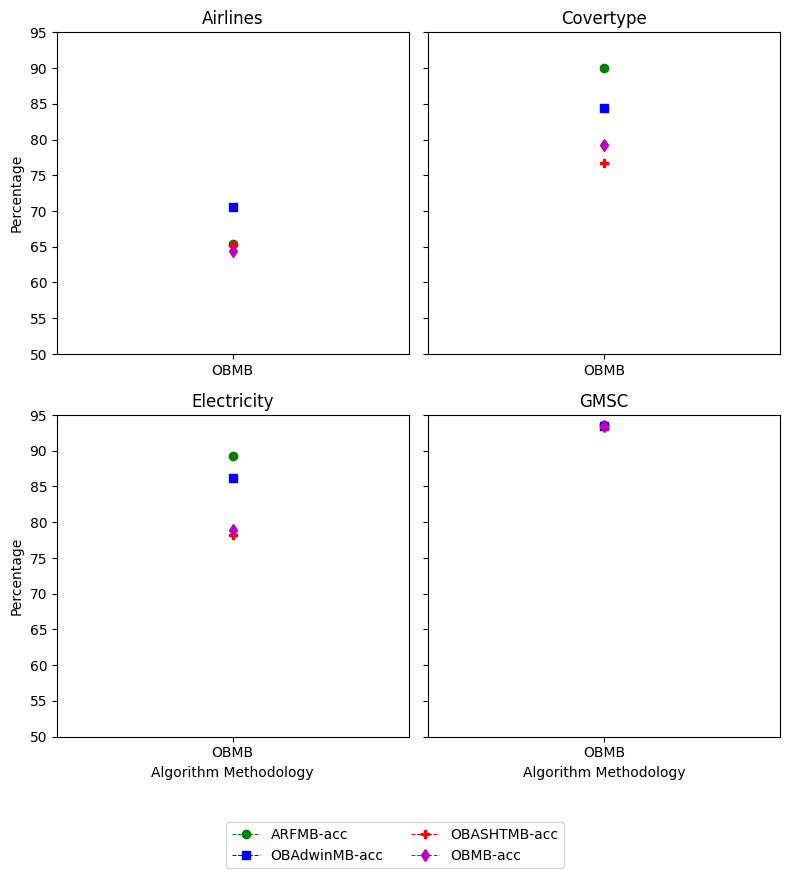

In [15]:
#false makes the chart without markers
gen_chart(df)

Pegando o dataset Electricity e sua precisão e recall podemos observar que ao utilizar o os batch-sizes de tamanho entre 25 à 100 eles pedem um pouco em relação ao MOA comum e ao MOA paralelo. No dataset GMSC para o algoritmo OzaBag temos uma linha estável de precisão e recall para todos os cenários. O algoritmo OzaBag também em outros datasets é o que mais tem estabilidade ao utilizar o mini-batching ou sem ele. Já no dataset covertype podemos observar uma linha um pouco mais de instabilidade ao adicionamos a paralelização no algoritmos, alguns casos descem como o Ozabag e outros como o LBag melhoram a precisão porém com os mini-batchs esses dados são estabilizados.

# Consumer Energy 


In [16]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/-dynamic-batch'

In [17]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [18]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)

    return df[['algorithm', 'dataset', 'cores',
               'instances', 'time', 'delay', 'out_rate', 'acc']]

# Read Energy Data

In [19]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [20]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')

                if len(spline) == 2:
                    dataset,algorithm = spline
                else:
                    dataset,algorithm = *spline,1

                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}

            
                d[algorithm][dataset] = {'start': date_time_obj, 'finish': ''}
                dnow = d[algorithm][dataset]

                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True

    return d

In [21]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            st = v1['start']
            ed = v1['finish']
            v1['seconds'] = (ed - st).seconds
            new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                        & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
            v1['avg_measure'] = new_df['measure'].mean()
            v1['sum_measure'] = new_df['measure'].sum()
            v1['avg_times_seconds'] = v1['avg_measure'] * v1['seconds']
    return d

In [22]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            dappend['algorithm'].append(kalg)
            dappend['dataset'].append(kds)
            dappend['ensemble_size'].append(25)
            dappend['cores'].append(4)
            dappend['batch_size'].append('Dynamic')
            dappend['duration'].append(vds['seconds'])
            dappend['inc_rate'].append(100)
            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                dappend[key].append(vds[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH Logs

In [23]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg = spline[1:]
                    else:
                        dataset, alg = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d)

# Showing and preparing for charts

In [24]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [25]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [26]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15
    alg_order = ['B25', 'B50', 'B75', 'B100']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 4
    for i in range(versions):
        adf = df.iloc[i]
        values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [27]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset']).sort_values(['algorithm'])
       
        # debug print, if it shows it is wrong
        # if len(showdf) != 5:
        #     display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [28]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, freq='600', tput=False):
    ps = f'{freq}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']

    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = True
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/figures/{freq}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

In [29]:

def debug(df):
    df = select_columns_and_rename_values(df)
    datasets = ['GMSC']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    dfalg = filter_by_substring_algorithm(df, alg)
    for ds in datasets:
        dsdf = dfalg[(dfalg.dataset == ds)]

# Run methods to obtained visible results

In [38]:
def read_data_create_final_dataframe(DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    folder_path = f"{PATH_TO_RESULTS}/results/dynamic-batch-cpu"

    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')

    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')

    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset'])
    
    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['IPS'] = finaldf['instances'] / finaldf['time']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm'], ascending=False)

    tdf['tput'] = tdf['instances'] / tdf['time']
    tdf.to_csv(f"{PATH_TO_RESULTS}/results/dynamic-batch.csv")    
    return tdf

In [39]:
pd.set_option('display.precision', 10)

dataframes = []
dataframes.append(read_data_create_final_dataframe(True))
display(dataframes[0])


moaDF: 22    mdf: 22     sshDF: 30


,algorithm,dataset,cores_x,instances,time,delay,acc,ensemble_size,inc_rate_x,cores_y,...,avg_measure,sum_measure,inc_rate_y,prod_rate,tt_inst_prod,avg_times_duration,joules,IPS,JPI,tput
11,StreamingRandomPatchesExecutorMAXChunk,elecNormNew,4,"26,501.00",119.88,"1,929.00",90.18,25,100,4,...,4.09,969.80,NaN,NaN,NaN,536.05,490.53,221.07,0.02,221.07
20,OzaBagExecutorMAXChunk,elecNormNew,4,"26,501.00",119.88,596.00,78.91,25,100,4,...,3.03,723.50,NaN,NaN,NaN,399.59,362.89,221.07,0.02,221.07
13,OzaBagAdwinExecutorMAXChunk,elecNormNew,4,"26,501.00",119.86,667.00,86.16,25,100,4,...,3.20,770.10,NaN,NaN,NaN,424.99,383.00,221.10,0.02,221.10
4,OzaBagASHTExecutorMAXChunk,elecNormNew,4,"26,501.00",119.88,624.00,78.20,25,100,4,...,3.07,736.00,NaN,NaN,NaN,404.80,367.62,221.07,0.02,221.07
10,AdaptiveRandomForestExecutorMAXChunk,elecNormNew,4,"27,001.00",120.23,"1,592.00",89.33,25,100,4,...,3.70,887.40,NaN,NaN,NaN,488.07,444.54,224.58,0.02,224.58
12,StreamingRandomPatchesExecutorMAXChunk,covtypeNorm,4,"31,001.00",121.45,"1,909.00",92.86,25,100,4,...,4.90,"1,179.80",NaN,NaN,NaN,651.09,594.57,255.25,0.02,255.25
21,OzaBagExecutorMAXChunk,covtypeNorm,4,"294,001.00",120.00,200.00,79.30,25,100,4,...,4.60,"1,099.40",NaN,NaN,NaN,607.20,552.01,"2,449.97",0.00,"2,449.97"
1,OzaBagAdwinExecutorMAXChunk,covtypeNorm,4,"81,551.00",120.01,36.00,84.47,25,100,4,...,4.65,"1,120.00",NaN,NaN,NaN,618.09,557.70,679.56,0.01,679.56
0,OzaBagASHTExecutorMAXChunk,covtypeNorm,4,"294,501.00",120.08,200.00,76.67,25,100,4,...,4.59,"1,111.90",NaN,NaN,NaN,611.09,551.73,"2,452.50",0.00,"2,452.50"
15,LBagExecutorMAXChunk,covtypeNorm,4,"81,501.00",120.11,719.00,90.28,25,100,4,...,5.13,"1,226.00",NaN,NaN,NaN,677.12,616.13,678.55,0.01,678.55


In [32]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    return df




----------------------------------


AttributeError: 'DataFrame' object has no attribute 'PERC'

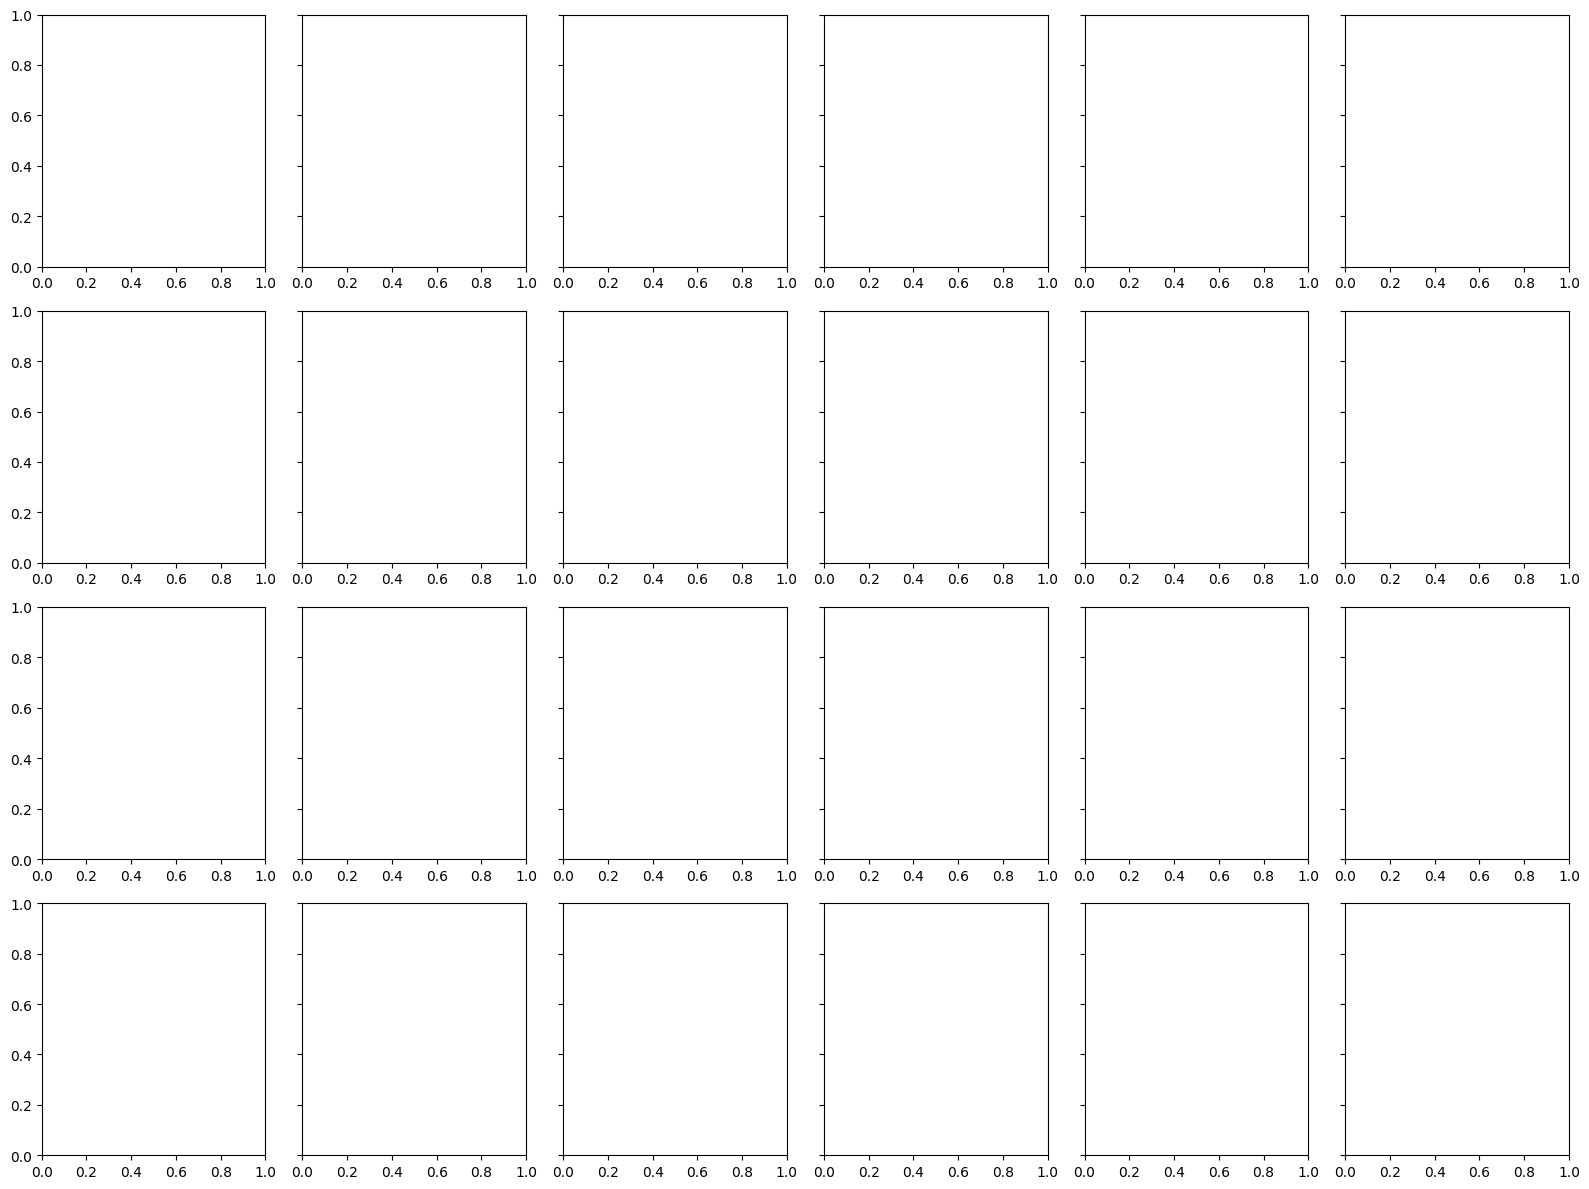

In [33]:
print(f'\n\n\n----------------------------------')
df = select_columns_and_rename_values_basic(df)
gen_graph(df, bars=True, freq=f"")

Neste gráfico podemos analisar a quantidade de Joules por instancia (JPI) para cada taxa de saída 10%, 50%, 90%. A taxa de saída representa a quantidade de instancias que serão enviadas ao socket para serem processadas para obtenção do tamanho necessário do mini-batch a ser processado. Pois bem, podemos ver que em todos os algoritmos quanto maior a taxa de saída menor é o JPI e também seu delay, o delay é o tempo necessário que o algoritmo vai ficar em standby para fazer um novo processamento. Analisando todos os casos podemos ver que os algorimos OzaBag obtém um melhor desempenho energético em relação aos outros algoritmos. Segundo o trabalho do Cassales, isso se dever pela limitação do tamanho da estrutura de dados que ele carrega para processar em relação aos outros algoritmos processados.

# Average Consumer By Frequency

In [209]:
for df in zip(dataframes):
    print(f'\n\n\n----------------- {f} -----------------')
    df['joules'] = df['joules'].replace(np.nan, 0)
    df = df.reset_index()

    total = 0
    average = 0 
    for index, row in df.iterrows():
        if int(row['joules']) > 0:
            total += row['joules']

    average = total / len(df.index)
    print(average)




----------------- {'minimum': '600', 'maximum': '1200'} -----------------


TypeError: tuple indices must be integers or slices, not str

Este é o consumo médio em Joules gasto pela aplicação durante toda sua execução

# Compare Accuracy and IPS

- The IPS has some ligation when accuracy?
- IPS is minor when is frequency is minimum?
- IPS is major when is frequency is maximum?
- IPS is major when utilized mini-batching?

In [228]:
def plot(ax, dsdf, my_id, x):
    display(dsdf)
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ds = list(dsdf.dataset)
    # ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Acuraccy')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.batch_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.plot(x, pd.to_numeric(dsdf.JPI), color=c3, label='JPI')
    ax3.tick_params(axis='y', labelcolor=c3)
    ax3.spines["right"].set_position(("axes", 1.14))
    ax3.set_label('JPI')
    if int(my_id/2) == 1:
        ax.set_xlabel('Batch size')
        ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=5)
        ax3.legend(loc='upper center', bbox_to_anchor=(1, -0.20), fancybox=True, shadow=True, ncol=5)

In [224]:
def new_plot(ax, dsdf, my_id, x, fig):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype', 'kyoto_binary': 'Kyoto'}
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    global twin1
    global twin2
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ds = list(dsdf.dataset)[0]
    # ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Acuraccy')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.batch_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    ax3 = ax.twinx()
    ax3.plot(x, pd.to_numeric(dsdf.JPI), color=c3, label='JPI')
    ax3.tick_params(axis='y', labelcolor=c3)
    ax3.spines["right"].set_position(("axes", 1.14))
    ax3.set_label('JPI')
    if int(my_id/2) == 1:
        ax.set_xlabel('Batch size')
        ax.legend(loc='upper center', bbox_to_anchor=(0, -0.20), fancybox=True, shadow=True, ncol=5)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), fancybox=True, shadow=True, ncol=5)
        ax3.legend(loc='upper center', bbox_to_anchor=(1, -0.20), fancybox=True, shadow=True, ncol=5)


In [212]:
def gen_graph_initial_peralg_joules(df, display_df=False):
    datasets = ['GMSC']
    algorithms = ['ARF', 'LBag', 'OBAdwin', 'OBASHT', 'OB']
#     algorithms = ['LBag']
    alg_formal_name = {'ARF': 'AdaptiveRandomForest', 'LBag': 'LeveragingBag', 'SRP':'StreamingRandomPatches', 
                                                'OBAdwin':'OzaBagAdwin', 'OBASHT':'OzaBagASHT', 'OB':'OzaBag'}
    global twin1
    global twin2
    if display_df:
        display(df)
    df = select_columns_and_rename_values(df)
    if display_df:
        display(df)
    for alg in algorithms:
        filename = f"{alg}-sizeVS3"
        fig, axs = plt.subplots(3, 2, figsize=(10,8))
        twin1 = twin2 = axs[0][0]
        axs[2][1].set_visible(False)
        dfalg = filter_by_substring_algorithm(df, alg)
        if display_df:
            display(dfalg)
#         fig.suptitle(f'{alg_formal_name[alg]}')
        for ds in datasets:
#             display(dfalg)
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
                if alg == 'SRP':
                    display(dsdf)
            my_id = datasets.index(ds)
            if my_id == 4:
                pass
            ax = axs[int(my_id/2)][my_id%2]
            new_plot(ax, dsdf, my_id, x, fig)

        fig.tight_layout(pad=0.5)
#         print('pos:', axs[2][0].get_position(), '\nanchor:',axs[2][0].get_anchor())
        x0=0.05081018518518519
        y0=0.03703703703703709
        x1=0.4019981060606061
        y1=0.28742283950617287
        axs[2][0].set_position([x0+0.25, y0, x1-x0, y1-y0])
#         plt.savefig(f'{filename}.eps', bbox_inches='tight')
        
        
        lines_1, labels_1 = axs[0][0].get_legend_handles_labels()
        lines_2, labels_2 = twin1.get_legend_handles_labels()
        lines_3, labels_3 = twin2.get_legend_handles_labels()
        lines = lines_1 + lines_2 + lines_3
        labels = labels_1 + labels_2 + labels_3
        lgd = fig.legend(lines, labels, loc=3, ncol=1, bbox_to_anchor=(0.05, 0.1), prop={'size': 14})
#         lgd.set_in_layout(True)
#         fig.subplots_adjust(bottom=0.2)
        
        plt.savefig(f'Pi-{filename}.eps', pad_inches=1.5)
        print(filename)
        plt.savefig(f'Pi-{filename}.png', pad_inches=1.5)

In [219]:
def gen_graph_initial_peralg(df, display_df=False, freq=''):
    datasets = ['GMSC']

    algorithms = ['ARF', 'LBag', 'OBAdwin', 'OBASHT', 'OB']
    #algorithms = ['OB']
    filename = f"pi-rates"
    for alg in algorithms:
        fig, axs = plt.subplots(2, 2, figsize=(14,9))
        # set the spacing between subplots
        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)
        dfalg = filter_by_substring_algorithm(df, alg)
        fig.suptitle(f'{alg} - Frequency {freq}')
        for ds in datasets:
            dsdf = dfalg[(dfalg.dataset == ds)]
            dsdf.batch_size = 'dynamic'
            x = np.arange(len(dsdf.batch_size))
            my_id = datasets.index(ds)
            ax = axs[int(my_id/2)][my_id%2]
            plot(ax, dsdf, my_id, x)
        plt.savefig(f'{filename}.eps', bbox_inches='tight')

In [237]:
dataframes = []
dataframes.append(read_data_create_final_dataframe(True))

  dataset                             algorithm  ensemble_size  cores  \
0    GMSC                  LBagExecutorMAXChunk             25      4   
1    GMSC                OzaBagExecutorMAXChunk             25      4   
2    GMSC            OzaBagASHTExecutorMAXChunk             25      4   
3    GMSC           OzaBagAdwinExecutorMAXChunk             25      4   
4    GMSC  AdaptiveRandomForestExecutorMAXChunk             25      4   

   instances   time  delay  out_rate   acc  
0 149,810.00  84.62 431.00  1,770.28 93.57  
1 149,237.00  40.71 187.00  3,666.31 93.31  
2 149,850.00  42.94 154.00  3,489.92 93.28  
3 149,624.00  53.24 259.00  2,810.32 93.43  
4 142,925.00 120.02 614.00  1,190.82 93.57  
v {'start': datetime.datetime(2023, 8, 7, 17, 8, 24), 'finish': datetime.datetime(2023, 8, 7, 17, 11, 40)}
v {'start': datetime.datetime(2023, 8, 7, 17, 11, 41), 'finish': datetime.datetime(2023, 8, 7, 17, 14, 23)}
v {'start': datetime.datetime(2023, 8, 7, 17, 14, 24), 'finish': datetime.da

,algorithm,dataset,cores,instances,time,delay,acc
0,LBagExecutorMAXChunk,GMSC,4,"149,810.00",84.62,431.00,93.57
1,OzaBagExecutorMAXChunk,GMSC,4,"149,237.00",40.71,187.00,93.31
2,OzaBagASHTExecutorMAXChunk,GMSC,4,"149,850.00",42.94,154.00,93.28
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,"149,624.00",53.24,259.00,93.43
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,"142,925.00",120.02,614.00,93.57


,algorithm,dataset,ensemble_size,inc_rate,cores,duration,avg_measure,sum_measure
0,AdaptiveRandomForestExecutorMAXChunk,GMSC,25,100,4,196,4.51,"4,642.00"
1,LBagExecutorMAXChunk,GMSC,25,100,4,162,3.99,"3,396.60"
3,OzaBagASHTExecutorMAXChunk,GMSC,25,100,4,121,3.31,"2,114.90"
2,OzaBagAdwinExecutorMAXChunk,GMSC,25,100,4,212,3.42,"3,814.00"
4,OzaBagExecutorMAXChunk,GMSC,25,100,4,122,3.47,"2,211.80"


,algorithm,dataset,inc_rate,prod_rate,tt_inst_prod
0,AdaptiveRandomForestExecutorMAXChunk\n,GMSC,,"3,349.34","150,000.00"
1,LBagExecutorMAXChunk\n,GMSC,,"3,486.61","150,000.00"
2,StreamingRandomPatchesExecutorMAXChunk\n,GMSC,,"3,691.35","150,000.00"
3,OzaBagASHTExecutorMAXChunk\n,GMSC,,"3,495.14","150,000.00"
4,OzaBagExecutorMAXChunk\n,GMSC,,"3,676.31","150,000.00"


moaDF: 5    mdf: 5     sshDF: 5


,algorithm,dataset,cores_x,instances,time,delay,acc,ensemble_size,inc_rate_x,cores_y,duration,avg_measure,sum_measure,inc_rate_y,prod_rate,tt_inst_prod,avg_times_duration,joules,IPS,JPI
0,LBagExecutorMAXChunk,GMSC,4,"149,810.00",84.62,431.00,93.57,25,100,4,162,3.99,"3,396.60",NaN,NaN,NaN,645.83,337.37,"1,770.28",0.00
1,OzaBagExecutorMAXChunk,GMSC,4,"149,237.00",40.71,187.00,93.31,25,100,4,122,3.47,"2,211.80",NaN,NaN,NaN,422.95,141.11,"3,666.31",0.00
2,OzaBagASHTExecutorMAXChunk,GMSC,4,"149,850.00",42.94,154.00,93.28,25,100,4,121,3.31,"2,114.90",NaN,NaN,NaN,401.10,142.33,"3,489.92",0.00
3,OzaBagAdwinExecutorMAXChunk,GMSC,4,"149,624.00",53.24,259.00,93.43,25,100,4,212,3.42,"3,814.00",NaN,NaN,NaN,725.82,182.28,"2,810.32",0.00
4,AdaptiveRandomForestExecutorMAXChunk,GMSC,4,"142,925.00",120.02,614.00,93.57,25,100,4,196,4.51,"4,642.00",NaN,NaN,NaN,883.33,540.91,"1,190.82",0.01


,algorithm,dataset,cores_x,instances,time,delay,acc,ensemble_size,inc_rate_x,cores_y,...,sum_measure,inc_rate_y,prod_rate,tt_inst_prod,avg_times_duration,joules,IPS,JPI,PERC,tput


ValueError: x and y must have same first dimension, but have shapes (7,) and (0,)

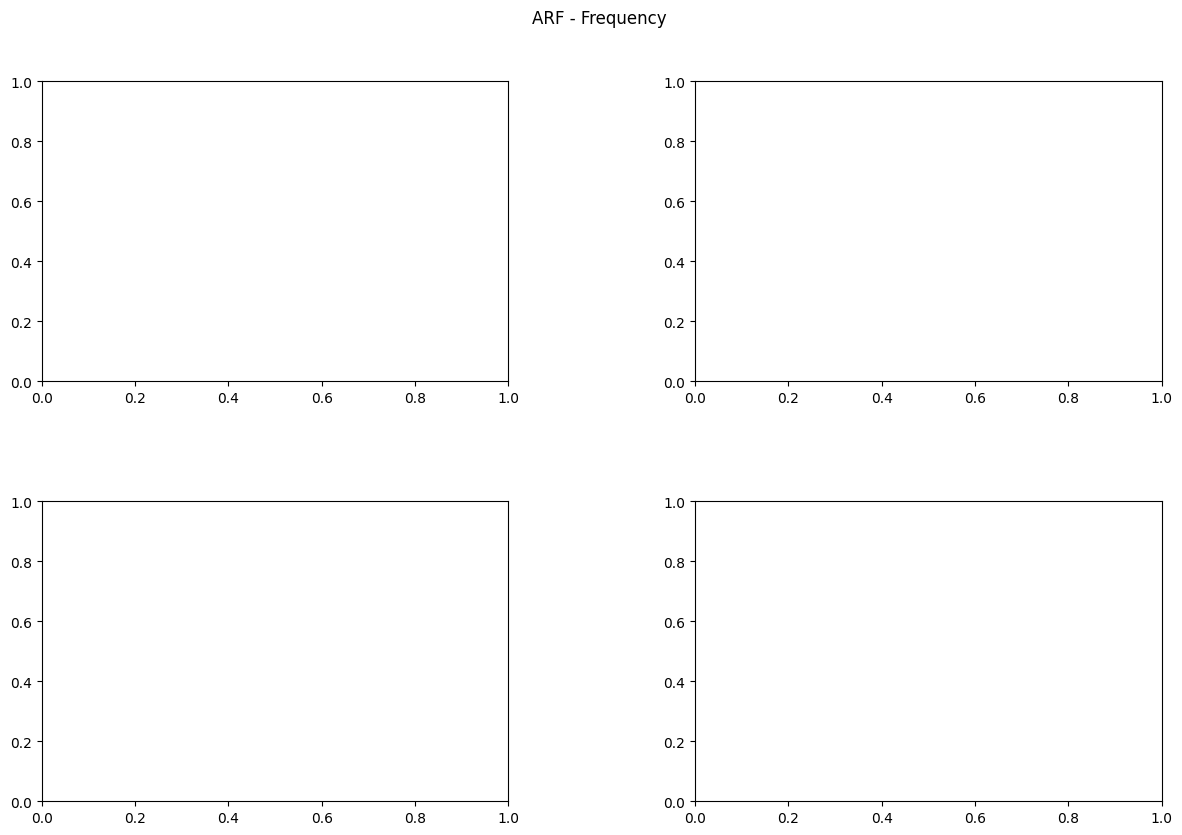

In [238]:
df = dataframes[0]
gen_graph_initial_peralg(df, display_df=False)


Agora iremos analisar a relação entre o número de instancias processadas por segundo (IPS) o JPI e a acurácia entre esses valores. Primeiro vamos analisar a linha azul que representa o IPS, individualmente irei analisar primeiro o dataset Airlines nos algoritmos Adaptive Random Forest (ARF), OzaBag (OB), LBag (LB). Para o ARF o IPS inicia com um processamento de 84 instancias e evolui para 94 no batch-size de tamanho 50 e cai para 88 no batch-size 75 e 100. A linha verde representa o JPI neste primeiro algoritmo observamos o comportamento de queda no maior numero de IPS mas no batch-size de 75 e 100 um novo aumento. No algoritmo OB temos um aumento no número de IPS em relação ao tamnho do batch-size somente caindo no 100. Já o número do JPI diminui em relação ao aumento do IPS exceto na quanto o IPS cai no batch-size 100. Por último vamos analisar o LB, para este algoritmo a tendência do batch-size aumenta o IPS diminui e o JPI tende a crescer. Vendo esses casos podemos dizer que para os algoritmos ARF e OB a têndencia é quanto maior o IPS menor será o JPI já no LBAG o oposto aconteceu pelo menos no dataset airlines, quanto menor o IPS maior o JPI. Já em outros dasets ocorreu de o IPS maior trazer um menor JPI.

# Conclusoes

Neste cenário podemos observar que o tamanho do mini-batch não traz grande diferença no consumo energético quando seu tamanho é menor ou maior, mas sim em relação ao seu padrão de comportamento sequencial já comprovado no artigo do Cassales. Nesta analise constatamos alguns comportamentos tais como quando a quantidade de IPS aumenta em determinados algoritmos temos uma tendencia que o JPI diminua e que existem algoritmos que são mais eficiente energéticamente e mantem a mesma linha de precisão e acurácia como o OzaBag.